In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
import joblib
from tqdm import tqdm

# Define MAPE function
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

# Load the dataset
df = pd.read_csv('Train.csv')

# Convert the 'date_time' column to datetime and sort the dataset
df['date_time'] = pd.to_datetime(df['date_time'])
df.sort_values('date_time', inplace=True)
df.set_index('date_time', inplace=True)

# One-hot encode categorical features
df = pd.get_dummies(df, columns=['is_holiday', 'weather_type', 'weather_description'], drop_first=True)

# Feature engineering: create lagged and rolling features
target = 'traffic_volume'
for i in range(1, 4):
    df[f'traffic_volume_lag_{i}'] = df[target].shift(i)
df['traffic_volume_rolling_mean'] = df[target].rolling(window=3).mean().shift(1)
df['traffic_volume_rolling_std'] = df[target].rolling(window=3).std().shift(1)

# Remove rows with NaN values resulting from lagged features
df.dropna(inplace=True)

# Split the dataset into features and the target
X = df.drop(target, axis=1)
y = df[target]

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the scaled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

# Initialize and train the SVR model
svr_model = SVR(C=1.0, epsilon=0.1)

# Training the SVR model (you can use tqdm to show a progress bar if desired)
svr_model.fit(X_train, y_train)

# Predict on the test set
y_pred = svr_model.predict(X_test)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

traffic_volume_range = df[target].max() - df[target].min()

# Normalize RMSE and MAE
normalized_rmse = rmse / traffic_volume_range
normalized_mae = mae / traffic_volume_range

# Output the metrics
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Normalized Root Mean Squared Error (RMSE): {normalized_rmse}")
print(f"Normalized Mean Absolute Error (MAE): {normalized_mae}")
print(f"R-squared (R2): {r2}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

# Save the SVR model for later use
joblib.dump(svr_model, 'svr_model.pkl')


Root Mean Squared Error (RMSE): 1529.0774948487272
Mean Absolute Error (MAE): 1317.5262560881145
Normalized Root Mean Squared Error (RMSE): 0.21003811742427572
Normalized Mean Absolute Error (MAE): 0.18097888133078496
R-squared (R2): 0.3879026195843722
Mean Absolute Percentage Error (MAPE): 134.20367719554608%


['svr_model.pkl']

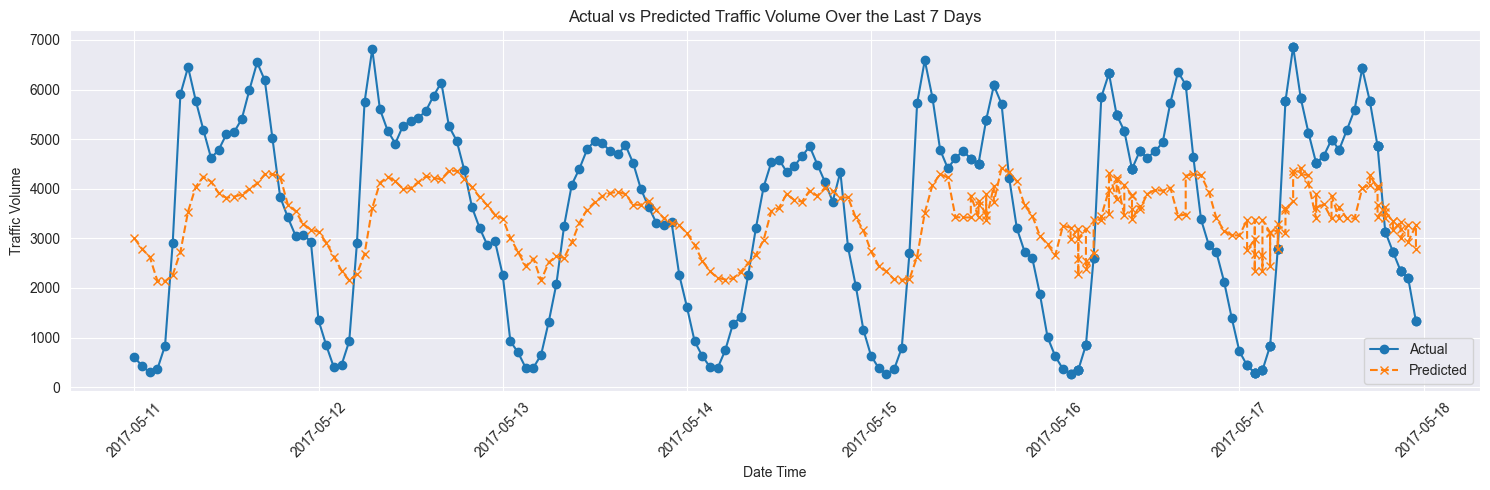

In [2]:
import matplotlib.pyplot as plt

# Assuming y_test and y_pred are already defined and are pandas Series
comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
comparison_df['date_time'] = y_test.index  # Assuming y_test still has the date_time index
comparison_df.set_index('date_time', inplace=True)

# Select the last 7 days of data for plotting
last_7_days = comparison_df.last('7D')  # '7D' for 7 days

# Plot the results
plt.figure(figsize=(15, 5))
plt.plot(last_7_days['Actual'], label='Actual', marker='o')
plt.plot(last_7_days['Predicted'], label='Predicted', marker='x', linestyle='--')
plt.title('Actual vs Predicted Traffic Volume Over the Last 7 Days')
plt.xlabel('Date Time')
plt.ylabel('Traffic Volume')
plt.legend()
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlapping
plt.show()
